In [1]:
# Import KmdPlus module.
from KmdPlus import KMD, StatsDescriptor, formula_to_composition 

# Import libraries.
import pandas as pd
import numpy as np
from pymatgen.core.composition import Composition
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the dataset for the KmdPlus tutorial.
# Chemical formulas of all stable materials listed in Materials Project (2022/08/07), and their formation energies.
MP_stable = pd.read_csv("data_set/MP_stable_formula_20220807.csv", index_col= 0)

# Element-level descriptors of shape (94, 58).
element_features = pd.read_csv("data_set/element_features.csv", index_col= 0)

In [2]:
MP_stable

,formula_pretty,formation_energy_per_atom
0,Zn2B2PbO6,-2.255461
1,Nd4GaSbS9,-1.839540
2,Tm2Pt,-0.991841
3,CsRb2MoF6,-2.890416
4,Ta3(BiS3)2,-1.172122
...,...,...
35458,PbCl4,-1.107566
35459,Nd2Hf2O7,-3.980813
35460,Lu3Ni2Ge3,-0.819758
35461,Cs2HgF4,-2.445423


In [3]:
# Convert chemical formulas to compositions.
MP_weight = np.array([formula_to_composition(MP_stable.iloc[i]["formula_pretty"]) for i in range(MP_stable.shape[0])])
component_features = element_features

print(MP_weight.shape)
print(component_features.shape)

(35463, 94)
(94, 58)


In [4]:
# Generate the kernel mean descriptors (KMD) for each feature, then combine them.
kmd_1d = KMD("1d") # Unidimensional KMD; the kernel mean is discretized at the n_grids equally spaced grids 
                   # between a maximum and minimum values for each feature.

# Generate 2 types of descriptors with the default settings (materials → descriptors).
kmd1d = kmd_1d.transform(MP_weight, component_features, 10)
ssd = StatsDescriptor(MP_weight, component_features)

# Scaling the summary statistics descriptors (SSD).
ssd_scaled = (ssd - ssd.mean(axis=0))/ssd.std(axis=0, ddof=1)
formation_energy = np.array(MP_stable["formation_energy_per_atom"])

print(kmd1d.shape)
print(ssd_scaled.shape)

(35463, 580)
(35463, 232)


In [5]:
# Inverse-translate the KMD into the weights of the components (descriptors → materials).
decoded_weight = kmd_1d.inverse_transform(kmd1d)

# Compute the reconstruction error between the weights used to generate the KMD and the decoded weights.
MAE = np.mean((abs(MP_weight - decoded_weight)).sum(1))
print(f"Reconstructuion error (MAE) is {MAE}.")
print("The weights used to generate the KMD were successfully reconstructed except for numerical errors.")

Reconstructuion error (MAE) is 3.8966397731785307e-13.
The weights used to generate the KMD were successfully reconstructed except for numerical errors.


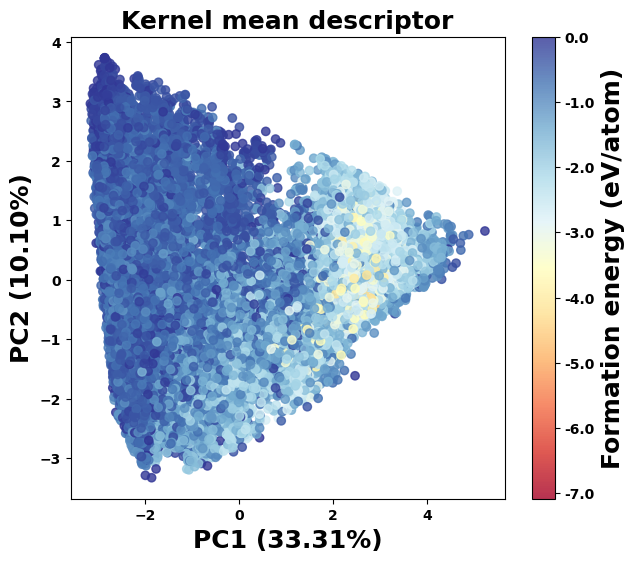

In [6]:
# PCA visualization of the KMD.

pca = PCA()
x = kmd1d
pca.fit(x)
feature = pca.transform(x)

cm = plt.colormaps.get_cmap('RdYlBu')
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(1, 1, 1)
mappable = ax.scatter(feature[:, 0], feature[:, 1], c=formation_energy,cmap=cm, alpha = 0.8)
cb = fig.colorbar(mappable, ax=ax)
cb.set_ticks(cb.ax.get_yticks()[1:]) # delete -8.0.
cb.ax.set_yticklabels(labels=cb.ax.get_yticks(),fontsize=10, weight='bold')
cb.set_label('Formation energy (eV/atom)', size=18, fontweight='bold')
plt.title(f"Kernel mean descriptor", fontsize=18, fontweight='bold')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=18, fontweight='bold')
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=18, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.show()

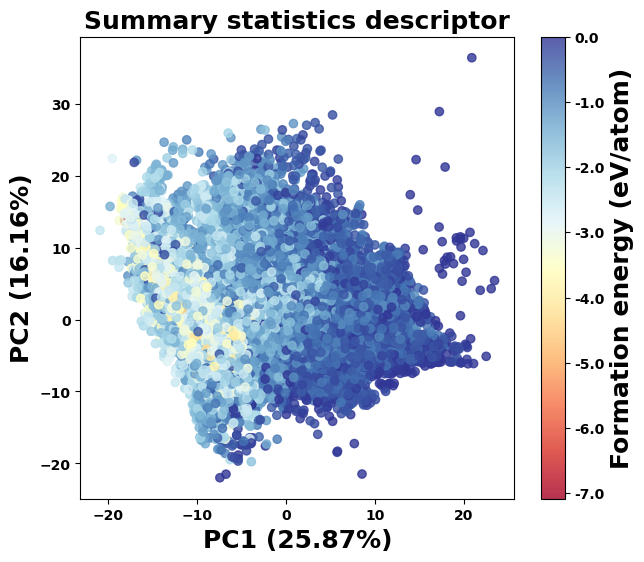

In [7]:
# PCA visualization of the SumarryStats descriptor ("mean", "var", "max", "min").

pca = PCA()
x = ssd_scaled
pca.fit(x)
feature = pca.transform(x)

cm = plt.colormaps.get_cmap('RdYlBu')
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(1, 1, 1)
mappable = ax.scatter(feature[:, 0], feature[:, 1], c=formation_energy,cmap=cm, alpha = 0.8)
cb = fig.colorbar(mappable, ax=ax)
cb.set_ticks(cb.ax.get_yticks()[1:])
cb.ax.set_yticklabels(labels=cb.ax.get_yticks(),fontsize=10, weight='bold')
cb.set_label('Formation energy (eV/atom)', size=18,  fontweight='bold')
plt.title(f"Summary statistics descriptor", fontsize=18, fontweight='bold')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=18, fontweight='bold')
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=18, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.show()